## Understanding Waveform Simulation for XENONnT

Nov 30

In [1]:
import strax, straxen, wfsim
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [2]:
config = straxen.get_resource('https://raw.githubusercontent.com/XENONnT/'
                 'strax_auxiliary_files/master/fax_files/fax_config_nt_design.json', fmt='json')
config.update({'detector':'XENONnT'})

### Part 2, Pulse (parent class)


The simulated pulses are formed using single-photon hits. Each hit has assigned time, channel, and gain using a common single photo-electron (SPE) shape.

**SPE Shape** is extracted from data and saved into a single template, with two entries in the config `pe_pulse_ts` and `pe_pulse_ys`. 

In [3]:
def init_pmt_current_templates():
    """
    Create spe templates, for 10ns sample duration and 1ns rounding we have:
    _pmt_current_templates[i] : photon timing fall between [10*m+i, 10*m+i+1)
    (i, m are integers)
    """
    global pe_pulse_function, _pmt_current_templates

    # Interpolate on cdf ensures that each spe pulse would sum up to 1 pe*sample duration^-1
    pe_pulse_function = interp1d(
        config.get('pe_pulse_ts'),
        np.cumsum(config.get('pe_pulse_ys')),
        bounds_error=False, fill_value=(0, 1))

    # Samples are always multiples of sample_duration
    sample_duration = config.get('sample_duration', 10)
    samples_before = config.get('samples_before_pulse_center', 2)
    samples_after = config.get('samples_after_pulse_center', 20)
    pmt_pulse_time_rounding = config.get('pmt_pulse_time_rounding', 1.0)

    # Let's fix this, so everything can be turned into int
    assert pmt_pulse_time_rounding == 1

    samples = np.linspace(-samples_before * sample_duration,
                          + samples_after * sample_duration,
                          1 + samples_before + samples_after)
    _template_length = np.int(len(samples) - 1)

    templates = []
    for r in np.arange(0, sample_duration, pmt_pulse_time_rounding):
        pmt_current = np.diff(pe_pulse_function(samples - r)) / sample_duration  # pe / 10 ns
        # Normalize here to counter tiny rounding error from interpolation
        pmt_current *= (1 / sample_duration) / np.sum(pmt_current)  # pe / 10 ns
        templates.append(pmt_current)
    _pmt_current_templates = np.array(templates)
    
init_pmt_current_templates()

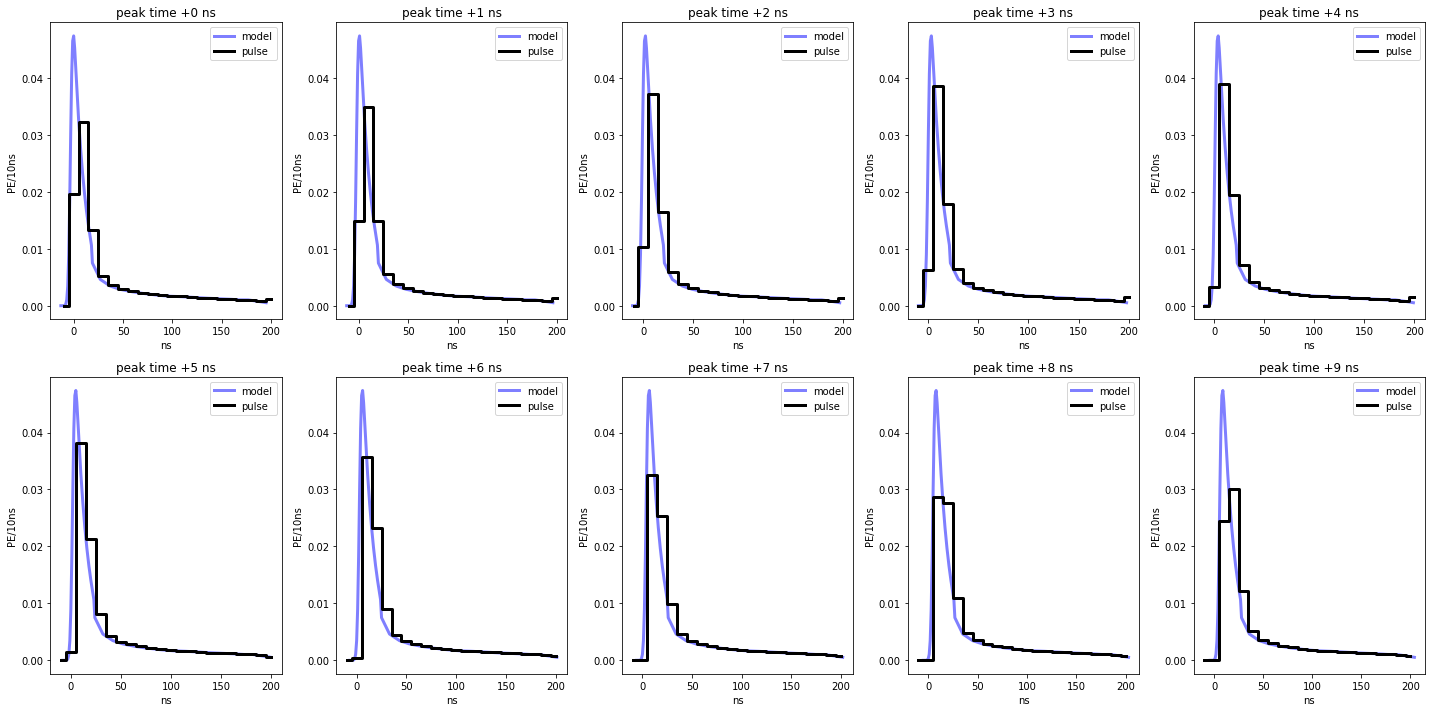

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, temp in enumerate(_pmt_current_templates):
    plt.sca(axes[i//5, i%5])

    # Pluse shape taken from config with 1 ns resolution
    plt.plot(np.array(config.get('pe_pulse_ts')) + i, config.get('pe_pulse_ys'), alpha=0.5, color='b', lw=3.0, label='model')
    # Caching 10 pulse shape templates with 10 ns resolution
    plt.step(np.arange(22) * 10 - 10, temp, alpha=1, lw=3.0, color='k', where='mid', label='pulse')

    plt.legend()
    plt.title('peak time +%d ns'%(i))
    plt.xlabel('ns')
    plt.ylabel('PE/10ns')

plt.tight_layout()
plt.show()

#### SPE gain mean and spread

While pax save gains in the config, strax uses the function `get_to_pe`. We are a bit careless here and hard code the conversion here to reintroduce `gains` into config

In [5]:
to_pe = straxen.get_to_pe(1, ('to_pe_per_run', 'https://raw.githubusercontent.com/XENONnT/'
                 'strax_auxiliary_files/master/fax_files/to_pe_nt.npy'),
    len(config['channels_in_detector']['tpc']))
config['gains'] = 1 / to_pe * (1e-8 * 2.25 / 2**14) / (1.6e-19 * 10 * 50)
config['gains'][to_pe==0] = 0

/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: to_pe_per_run will be replaced by CorrectionsManagementSevices
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [6]:
photon_area_distribution = straxen.get_resource('https://raw.githubusercontent.com/XENONnT/'
                 'strax_auxiliary_files/master/fax_files/XENONnT_spe_distributions.csv', fmt='csv')

def init_spe_scaling_factor_distributions():
    global grid_cdf, spe_shapes, __uniform_to_pe_arr
    # Extract the spe pdf from a csv file into a pandas dataframe
    spe_shapes = photon_area_distribution

    # Create a converter array from uniform random numbers to SPE gains (one interpolator per channel)
    # Scale the distributions so that they have an SPE mean of 1 and then calculate the cdf
    uniform_to_pe_arr = []
    for ch in spe_shapes.columns[1:]:  # skip the first element which is the 'charge' header
        if spe_shapes[ch].sum() > 0:
            mean_spe = (spe_shapes['charge'].values * spe_shapes[ch]).sum() / spe_shapes[ch].sum()
            scaled_bins = spe_shapes['charge'].values / mean_spe
            cdf = np.cumsum(spe_shapes[ch]) / np.sum(spe_shapes[ch])
        else:
            # if sum is 0, just make some dummy axes to pass to interpolator
            cdf = np.linspace(0, 1, 10)
            scaled_bins = np.zeros_like(cdf)

        grid_cdf = np.linspace(0, 1, 2001)
        grid_scale = interp1d(cdf, scaled_bins, 
            bounds_error=False, 
            fill_value=(scaled_bins[0], scaled_bins[-1]))(grid_cdf)

        uniform_to_pe_arr.append(grid_scale)

    if len(uniform_to_pe_arr):
        __uniform_to_pe_arr = np.stack(uniform_to_pe_arr)

def uniform_to_pe_arr(p, channel=0):
    indices = (p * 2000).astype(int)
    return __uniform_to_pe_arr[channel, indices]

init_spe_scaling_factor_distributions()

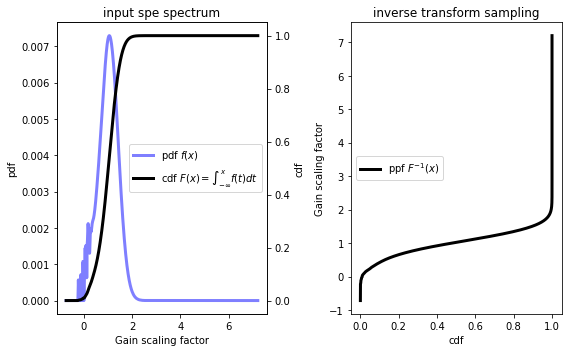

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))


plt.sca(axes[0])
ch = '0'
mean_spe = (spe_shapes['charge'].values * spe_shapes[ch]).sum() / spe_shapes[ch].sum()
scaled_bins = spe_shapes['charge'].values / mean_spe
cdf = np.cumsum(spe_shapes[ch]) / np.sum(spe_shapes[ch])

channel = int(ch)
l1, = plt.plot(scaled_bins, spe_shapes[ch], alpha=0.5, color='b', lw=3.0, label=r'pdf $f(x)$')
plt.xlabel('Gain scaling factor')
plt.ylabel('pdf')

axt = plt.twinx()
l2, = plt.plot(scaled_bins, cdf, alpha=1.0, color='k', lw=3.0, label=r'cdf $F(x)=\int_{-\infty}^{x}f(t)dt$')
#plt.plot(__uniform_to_pe_arr[channel], grid_cdf, alpha=0.5, color='k', lw=3.0, ls='--')
plt.ylabel('cdf')
plt.title('input spe spectrum')
plt.legend(handles=[l1, l2], loc='center right')


plt.sca(axes[1])
plt.plot(cdf, scaled_bins, alpha=1.0, color='k', lw=3.0, label=r'ppf $F^{-1}(x)$')
#plt.plot(grid_cdf, __uniform_to_pe_arr[channel], alpha=0.5, color='k', lw=3.0, ls='--', )
plt.xlabel('cdf')
plt.ylabel('Gain scaling factor')
plt.title('inverse transform sampling')
plt.legend(loc='center left')

plt.tight_layout()
plt.show()

The spe (gain scaling factor) pdf are saved on github, show in blue and coverted into ppf for the inverse transform sampling. So that we can map randomly genarated number between 0 and 1 to the scaling factor.

#### Add Current

In [ ]:
def add_current(photon_timings,
                photon_gains,
                pulse_left,
                dt,
                pmt_current_templates,
                pulse_current):
    #         """
    #         Simulate single channel waveform given the photon timings
    #         photon_timing         - dim-1 integer array of photon timings in unit of ns
    #         photon_gain           - dim-1 float array of ph. 2 el. gain individual photons
    #         pulse_left            - left of the pulse in unit of 10 ns
    #         dt                    - mostly it is 10 ns
    #         pmt_current_templates - list of spe templates of different reminders
    #         pulse_current         - waveform
    #         """
    if not len(photon_timings):
        return

    template_length = len(pmt_current_templates[0])
    i_photons = np.argsort(photon_timings)
    # Convert photon_timings to int outside this function
    # photon_timings = photon_timings // 1

    gain_total = 0
    tmp_photon_timing = photon_timings[i_photons[0]]
    for i in i_photons:
        if photon_timings[i] > tmp_photon_timing:
            start = int(tmp_photon_timing // dt) - pulse_left
            reminder = int(tmp_photon_timing % dt)
            pulse_current[start:start + template_length] += \
                pmt_current_templates[reminder] * gain_total

            gain_total = photon_gains[i]
            tmp_photon_timing = photon_timings[i]
        else:
            gain_total += photon_gains[i]
    else:
        start = int(tmp_photon_timing // dt) - pulse_left
        reminder = int(tmp_photon_timing % dt)
        pulse_current[start:start + template_length] += \
            pmt_current_templates[reminder] * gain_total

### Pulse Class Call Workflow

<img src="wfsim_intro_2.1.png" width="600">

In [ ]:
def clear_pulse_cache():
    global _pulses
    _pulses = []

__dict__ = {}

def call():
    """
    PMTs' response to incident photons
    Use _photon_timings, _photon_channels to build pulses
    """
    global _photon_timings, _photon_channels, turned_off_pmts

    # The pulse cache should be immediately transfered after call this function
    clear_pulse_cache()

    # Correct for PMT Transition Time Spread (skip for pmt afterpulses)
    _photon_timings += np.random.normal(config['pmt_transit_time_mean'],
                                        config['pmt_transit_time_spread'],
                                        len(_photon_timings))

    dt = config.get('sample_duration', 10) # Getting dt from the lib just once
    _n_double_pe = _n_double_pe_bot = 0 # For truth aft output

    counts_start = 0 # Secondary loop index for assigning channel
    for channel, counts in zip(*np.unique(_photon_channels, return_counts=True)):

        #TODO: This is temporary continue to avoid out-of-range error.
        # It should be added a proper method for nVeto PMTs also.
        if channel >= 2000:
            continue
        # Use 'counts' amount of photon for this channel 
        _channel_photon_timings = _photon_timings[counts_start:counts_start+counts]
        counts_start += counts
        if channel in turned_off_pmts: continue

        # If gain of each photon is not specifically assigned
        # Sample from spe scaling factor distribution and to individual gain
        # In contrast to pmt afterpulse that should have gain determined before this step
        if '_photon_gains' not in __dict__:
            if config['detector'] == 'XENON1T':
                _channel_photon_gains = config['gains'][channel] \
                * uniform_to_pe_arr(np.random.random(len(_channel_photon_timings)), channel)

            else:
                _channel_photon_gains = config['gains'][channel] \
                * uniform_to_pe_arr(np.random.random(len(_channel_photon_timings)))

            # Add some double photoelectron emission by adding another sampled gain
            n_double_pe = np.random.binomial(len(_channel_photon_timings),
                                             p=config['p_double_pe_emision'])
            _n_double_pe += n_double_pe
            if channel in config['channels_bottom']:
                _n_double_pe_bot += n_double_pe

            #_dpe_index = np.random.randint(len(_channel_photon_timings),
            #                               size=n_double_pe)
            if config['detector'] == 'XENON1T':
                _channel_photon_gains[:n_double_pe] += config['gains'][channel] \
                * uniform_to_pe_arr(np.random.random(n_double_pe), channel)
            else:
                _channel_photon_gains[:n_double_pe] += config['gains'][channel] \
                * uniform_to_pe_arr(np.random.random(n_double_pe))
        else:
            _channel_photon_gains = np.array(_photon_gains[_photon_channels == channel])

        # Build a simulated waveform, length depends on min and max of photon timings
        min_timing, max_timing = np.min(
            _channel_photon_timings), np.max(_channel_photon_timings)
        pulse_left = int(min_timing // dt) - int(config['samples_to_store_before'])
        pulse_right = int(max_timing // dt) + int(config['samples_to_store_after'])
        pulse_current = np.zeros(pulse_right - pulse_left + 1)

        add_current(_channel_photon_timings.astype(int),
                    _channel_photon_gains,
                    pulse_left,
                    dt,
                    _pmt_current_templates,
                    pulse_current)

        # For single event, data of pulse level is small enough to store in dataframe
        _pulses.append(dict(
            photons  = len(_channel_photon_timings),
            channel  = channel,
            left     = pulse_left,
            right    = pulse_right,
            duration = pulse_right - pulse_left + 1,
            current  = pulse_current,))